# Álgebra Linear aplicada à análise de crédito

### O principal tópico abordado nesse trabalho é a utilização de regressão logística para classificação de credores, classificando-os como bons ou mals.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

from collections import OrderedDict

# Bibliotecas de treinamento
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import RobustScaler

# PCA
from sklearn.decomposition import PCA

In [2]:
default = pd.read_csv("UCI_Credit_Card.csv",index_col="ID")
pd.set_option('display.max_columns', None)
default['EDUCATION']=np.where(default['EDUCATION'] == 5, 4, default['EDUCATION'])
default['EDUCATION']=np.where(default['EDUCATION'] == 6, 4, default['EDUCATION'])
default['EDUCATION']=np.where(default['EDUCATION'] == 0, 4, default['EDUCATION'])
default['MARRIAGE']=np.where(default['MARRIAGE'] == 0, 3, default['MARRIAGE'])
default.rename(columns = {'default.payment.next.month': "default"}, inplace = True)
default.rename(columns = lambda x: x.lower(), inplace = True)
default.head()


,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default
ID,,,,,,,,,,,,,,,,,,,,,,,,
1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


##  Descrição dos Dados(Features)

* **limit_bal**: Limite de crédito considerando o limite individual e familiar.

* **sex**: Gênero
    * 1 = Homem
    * 2 = Mulher

* **education**: Nível de escolaridade
    * 1 = Pós-Graduação
    * 2 = Universidade
    * 3 = Ensino Médio
    * 4 = Outros

* **marriage**: Estado Civil 
    * 1 = Casado(a)
    * 2 = Solteiro(a)
    * 3 = Outros

* **age**: Idade(Anos)

* **pay_0** até **pay_6**: Histórico de pagamentos entre os meses de Abril e Setembro de 2005.
    * Números Negativos = Pagou Adiantado
    * 0 = Pagou na data correta
    * 1 = Com um mês de atraso
    * 2 = Com dois meses de atraso, ...


* **bill_amt1** até **bill_amt6**: Dívida acumulada nos meses de Abril e Setembro de 2005.

* **pay_amt1** até **pay_amt6**: Montante pago em antecipado

* **default**:
    * 1 = Não pagou
    * 0 = Pagou
    
    

## Entendendo melhor os dados

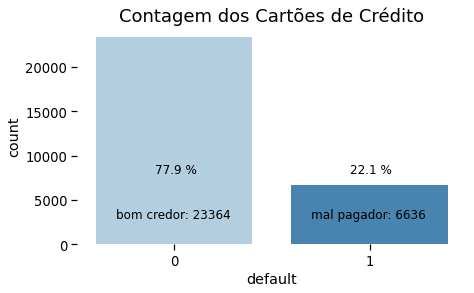

In [3]:
sim = default.default.sum()
nao = len(default)-sim

sim_perc = round(sim/len(default)*100, 1)
nao_perc = round(nao/len(default)*100, 1)
import sys 
plt.figure(figsize=(7,4))
sns.set_context('notebook', font_scale=1.2)
sns.countplot('default',data=default, palette="Blues")
plt.annotate('bom credor: {}'.format(nao), xy=(-0.3, 15000), xytext=(-0.3, 3000), size=12)
plt.annotate('mal pagador: {}'.format(sim), xy=(0.7, 15000), xytext=(0.7, 3000), size=12)
plt.annotate(str(nao_perc)+" %", xy=(-0.3, 15000), xytext=(-0.1, 8000), size=12)
plt.annotate(str(sim_perc)+" %", xy=(0.7, 15000), xytext=(0.9, 8000), size=12)
plt.title('Contagem dos Cartões de Crédito', size=18)

plt.box(False);

### Algumas renderizações dos dados.

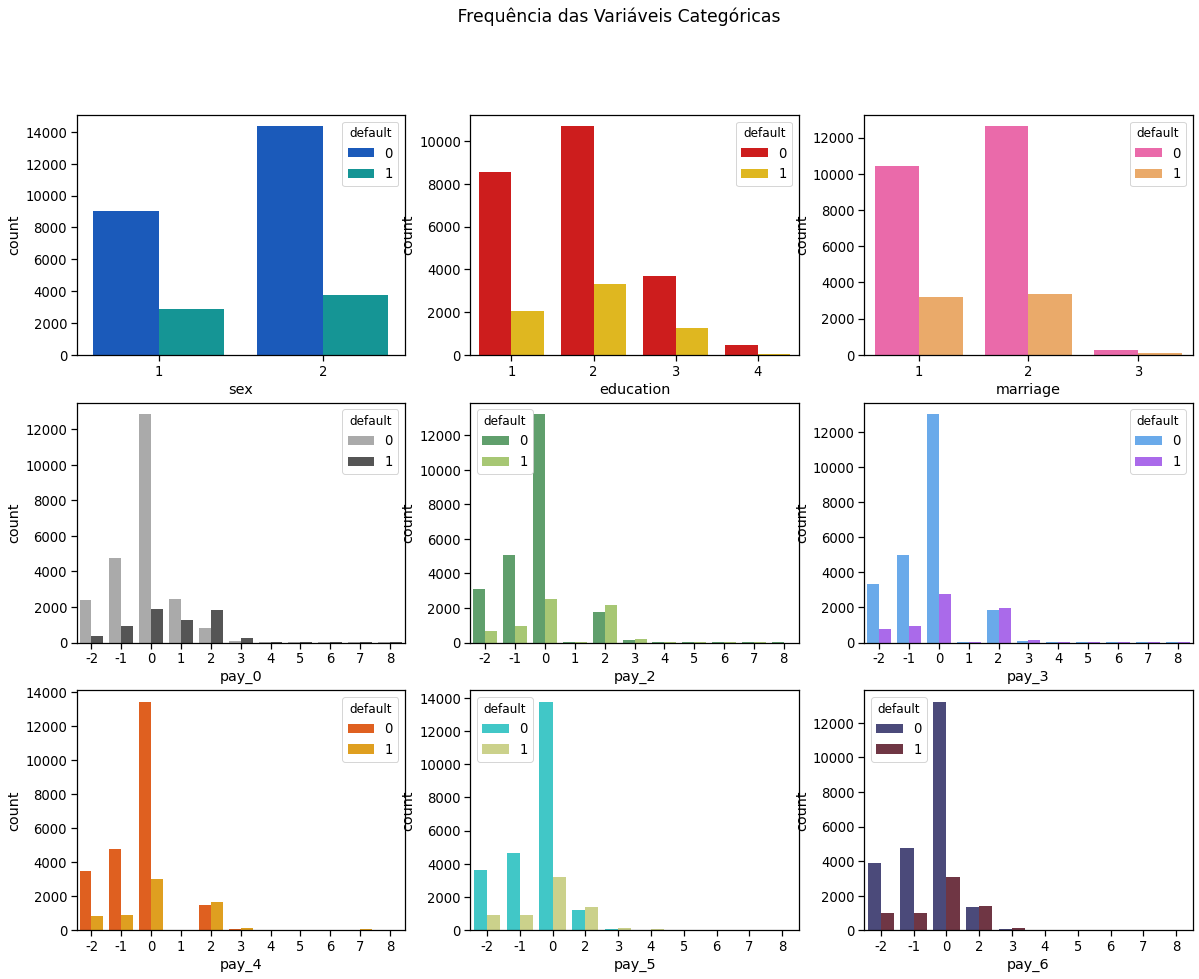

In [4]:
# Creating a new dataframe with categorical variables
subset = default[['sex','education','marriage','pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'default']]


f, axes = plt.subplots(3, 3, figsize=(20, 15), facecolor='white')
f.suptitle(' Frequência das Variáveis Categóricas')
ax1 = sns.countplot(x="sex", hue="default", data=subset, palette="winter", ax=axes[0,0])
ax2 = sns.countplot(x="education", hue="default", data=subset, palette="hot",ax=axes[0,1])
ax3 = sns.countplot(x="marriage", hue="default", data=subset, palette="spring",ax=axes[0,2])
ax4 = sns.countplot(x="pay_0", hue="default", data=subset, palette="binary", ax=axes[1,0])
ax5 = sns.countplot(x="pay_2", hue="default", data=subset, palette="summer", ax=axes[1,1])
ax6 = sns.countplot(x="pay_3", hue="default", data=subset, palette="cool", ax=axes[1,2])
ax7 = sns.countplot(x="pay_4", hue="default", data=subset, palette="autumn", ax=axes[2,0])
ax8 = sns.countplot(x="pay_5", hue="default", data=subset, palette="rainbow", ax=axes[2,1])
ax9 = sns.countplot(x="pay_6", hue="default", data=subset, palette="icefire", ax=axes[2,2]);

A partir da análise visual, é notável que mulheres(2), graduados(2), solteiros(2) e todos os que costumam pagar na data prevista tendem a ser bons credores.

## Preparação dos dados

Antes de realizar qualquer operação com os dados, é preciso que as informações estejam formatadas adequadamente. Diante disso, faz-se necessário dispor os dados qualitativos no formato binário, fazendo alterações semelhantes ao do exemplo abaixo:

Tabela exemplo:

| Sex: |
| :- |    
| Male |
| Female |

Tabela exemplo no formato binário:

|id| Male | Female |
|---|---|---|
| 1 | 1 | 0 |
| 2 | 1 | 0 |
| 3 | 0 | 1 |


Os dados da segunda tabela, nessa formatação, são denominados dummy features

In [5]:
#Formatando os dados
default['grad_school'] = (default['education']==1).astype('int')
default['university'] = (default['education']==2).astype('int')
default['high_school'] = (default['education']==3).astype('int')
default.drop('education', axis=1, inplace=True)

default['male'] = (default['sex']==1).astype('int')
default.drop('sex', axis=1,inplace=True)

default['married'] = (default['marriage'] == 1).astype('int')
default.drop('marriage', axis=1, inplace=True)
default.sample(2)

,limit_bal,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default,grad_school,university,high_school,male,married
ID,,,,,,,,,,,,,,,,,,,,,,,,,,
6972,20000.0,37,0,0,-2,-1,0,0,15960.0,0.0,-1953.0,5985.0,6893.0,8273.0,0.0,18047.0,7985.0,1000.0,2000.0,0.0,0,0,1,0,1,0
14075,90000.0,28,1,2,2,2,2,0,56889.0,55407.0,64428.0,64767.0,65579.0,67328.0,0.0,10000.0,2000.0,2000.0,3000.0,3000.0,1,1,0,0,0,0


Os indivíduos que antecipam os pagamentos ou pagam na data prevista são bons credores. Diante disso, é útil resumi-los a variável 0 nas colunas pay_0 a pay_6, uma vez que, a predição ficará menos complexa.

In [6]:
pay_features = ['pay_0', 'pay_2','pay_3','pay_4','pay_5','pay_6']

#Substituindo todos os valores negativos por 0
for p in pay_features:
    default.loc[default[p]<=0,p] = 0


## Regressão Linear
Vamos observar um exemplo com Regressão Linear e o porquê ela não é ideal para esse tipo de análise.

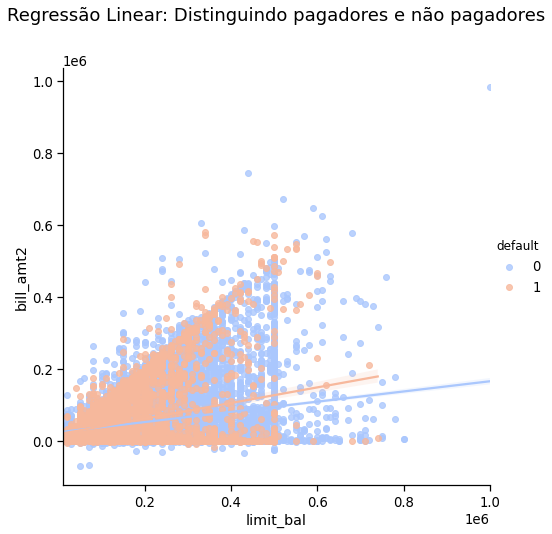

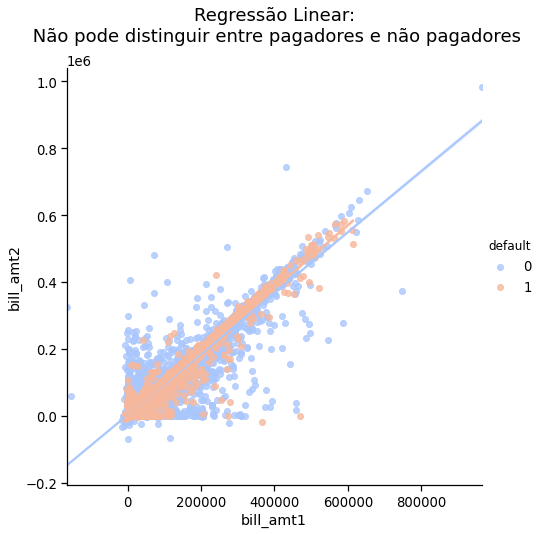

In [7]:
sns.lmplot(x='limit_bal', y= 'bill_amt2', data = default, hue ='default', 
           palette='coolwarm', height=7)
plt.title('Regressão Linear: Distinguindo pagadores e não pagadores\n\n', size=18)

sns.lmplot(x='bill_amt1', y= 'bill_amt2', data = default, hue ='default', 
           palette='coolwarm',height=7)
plt.title('Regressão Linear:\n Não pode distinguir entre pagadores e não pagadores\n', size=18);


Regressão Linear prediz com mais precisão modelos em que a saída é um valor contínuo, enquanto que, Regressão Logística modela melhor casos em que é necessário uma resposta binária como True or False.

# Regressão Logística 

A Regressão Logística é uma técnica estatística cujo o objetivo é predizer a ocorrência de um evento dado um cojunto de dados.

Nesse notebook, a Regressão Logística será usada para avaliar se um indivíduo é um bom credor, baseado em seus dados pessoais.


## Criando o Primeiro Modelo usando todos os dados

In [8]:
#Bibliotecas úteis do sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_score
from sklearn.preprocessing import RobustScaler

Como a Regressão Logí­stica é um modelo de Machine Learning supervisionado, é preciso separar do DataFrame as labels e os dados. Dessa forma, o modelo modificará os parâmetros de uma função para que as informações inseridas, de cada usuário, nessa função, resultem nos valores 0 ou 1. De modo que, esses valores binários corresponderão a classificação 0 (bom credor) ou 1 (mal pagador).

$$ f : R^n \rightarrow k \in [0,1]$$

In [9]:
#Armazenando as labels
y = default.copy()['default'] 
#Armazenando os dados
X = default.copy().drop('default', axis=1)

#### Normalizando os dados

Em tese, Regressão Logística não precisa de normalização de Dados, pois esta trabalha com probabilidades(veremos sobre isso adiante), porém a existência de outliers podem prejudicar a performance do modelo. Nesse sentido, a normalização faz-se necessária antes de implementar o modelo e para este fim, a função `RobustScaler`, do `SKLEARN`, é ideal, pois remove os valores que não estão entre o 1º e 2º quartil e normaliza os dados.

In [10]:
#Removendo os outliers
robust_scaler = RobustScaler()
X = robust_scaler.fit_transform(X)
X = pd.DataFrame(X, columns = default.drop("default", axis = 1).columns)

Em seguida, é necessário extrair alguns dados e labels de test, para que ao fim da modelagem sejam usados na avaliação da performance do modelo.

In [11]:
#Separando os dados de treino e test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.15, random_state = 123, stratify=y)

Após o tratamento dos dados, aparentemente, já é viável executar o modelo. Mas antes, vale entender a Matemática que compõe o modelo de Regressão Logí­stica.

### A Matemática da Regressão Logística



Como dito anteriormente, este é um método de aprendizado supervisionado, ou seja, o modelo realiza a tarefa de aprender uma função que mapeia uma entrada para obter uma saí­da, com base em pares de entrada-saí­da.

O termo Logística deriva do termo log odds, no qual, odds refere-se a razão entre a probabilidade de um evento acontecer e a probabilidade de não acontecer. O modelo recebeu este nome devido a utlização de log odds no cálculo da Regressão.

$$Odds = \frac{P(event)}{1-P(event)}$$


O gráfico da Regressão Logística é gerado a partir de uma função Sigmoide e uma das razões para usar essa curva é por se adequar melhor a modelos de classificação binária, uma vez que, os valores de saída podem ser interpretados como a probabilidade de um evento acontecer, já que estes variam entre 0 e 1.

$$p(X) = \frac {1}{1+e^{-BX}};  p(x) \in [0,1]; X,B \in R^n$$

<p align="center">
  <img width="250" height="200" src="https://raw.githubusercontent.com/AriOliv/AED/master/Sigmoide_Function.png">
</p>

A Regressão Logística estimará o parâmetro B de modo que função Sigmoide atinja a maior similaridade.

#### Estimando o parâmetro
- Suponha que exista $N$ amostras com labels 0 ou 1.
- Algumas amostras correspondem as Labels "1".
- Já outras amostras correspondem as Labels "0"
- O objetivo é estimar um B tal que, p(x) esteja o mais próximo de 1 nas amostras "1" e (1-p(x)) o mais próximo de 1 nas amostras "0"

$$
\prod_{s \space em \space yi=1}{p(x_i)} = p(x_1)*p(x_2)*...*p(x_n) \\
\prod_{s \space em \space yi=0}{1-p(x_i)} = (1-p(x_1))*(1-p(x_2))*...*(1-p(x_n))\\
$$
$$
L(B) = \prod_{s \space em \space yi=1}{p(x_i)} * \prod_{s \space em \space yi=0}{(1-p(x_i))}\\
L(B) = \prod_{s}{p(x_i)^{yi} * (1-p(x_i))^{1-y_i}}\\
$$


Aplicando log odds para isolar o parâmetro $BX$ e transformar o produtório em somatório


$$
log(L(B)) = log(\prod_{s}{p(x_i)^{yi} * (1-p(x_i))^{1-y_i}}) = l(b)\\
l(B)=\sum_{i=1}{y_i\log{(\frac{1}{1+e^{-Bx_i}})}+(1-y_i)\log{(1-p(x_i))}}\\
l(B)=\sum_{i=1}{y_iBx_i+\log{(\frac{1}{1+e^{Bx_i}})}}\\
l(B) = \sum_{i=1}Bx_i-\log{1+e^{Bx_i}}\\
B = arg \max_{B} l(B)
$$



Como essa equação é transcendental, não existe um B exato, entretanto, o Método de Newton oferece uma boa apromixação para este valor.

$$
B^{t+1} = B^{t}-\frac{\nabla_Bl(B^t)}{\nabla_{BB}l(B^t)}\\
$$

Calculando o gradiente $\nabla_Bl$

$$
\nabla_Bl = \sum_{i=1}{\nabla_B[y_iBx_i]-\nabla_B[log(1+e^{Bx_i})]}\\
\nabla_Bl = \sum_{i=1}{y_ix_i-[\frac{1}{1+e^{Bx_i}}e^{Bx_i}x_i]}\\
\nabla_Bl = \sum_{i=1}{y_ix_i-[\frac{1}{1+e^{-Bx_i}}x_i]}\\
\nabla_Bl = \sum_{i=1}{[y_i-p(x_i)]x_i}
$$

Convertendo para a representação matricial

$$\nabla_B = X^T(Y-\hat{Y})$$

Calculando o gradiente $\nabla_{BB}$, que é uma matrix de Hessian

$$
\nabla_{BB}l = \sum_{i=1}{\nabla_B[y_i-p(x_i)]x_i}\\
\nabla_{BB}l = \sum_{i=1}{\nabla_B-p(x_i)x_i}\\
\nabla_{BB}l = \sum_{i=1}{\nabla_B-[\frac{1}{1+e^{-Bx_i}}]x_i}\\
\nabla_{BB}l = \sum_{i=1}{[\frac{1}{1+e^{-Bx_i}}]^2 e^{-Bx_i}(-x_i)x_i}\\
\nabla_{BB}l = -\sum_{i=1}{[\frac{e^{-Bx_i}}{1+e^{-Bx_i}}][\frac{1}{1+e^{-Bx_i}}]x^T_ix_i}\\
\nabla_{BB}l = -\sum_{i=1}{p(x_i)(1-p(x_i))x^T_ix_i}\\
$$

Convertendo para forma matricial
$$
\nabla_{BB}l = -X^{T}P(1-P)X\\
\nabla_{BB}l = -X^{T}WX
$$

Desse modo, iterando a fórmula abaixo obtemos o parâmetro B.
$$
B^{t+1} = B^t+(X^{T}WX)^{-1}X^T(Y-\hat{Y}^{t})
$$

#### Perspectiva Geométrica da Regressão Logística

Quando é aplicado ""log odds"" na Função Sigmoide, obtém-se a reta $BX \in \rm I\!R^n$

<p align="center">
  <img width="270" height="150" src="https://raw.githubusercontent.com/AriOliv/AED/master/Sigmoid%20to%20line.png">
</p>

Ao calcular o vetor B com Método de Newton, geometricamente, a reta $BX$ rotacionará até que os coeficientes de B convirjam em um vetor que torna a função Sigmoide o mais similar possível.

<p align="center">
  <img width="270" height="150" src="https://raw.githubusercontent.com/AriOliv/AED/master/Parameter%20B.gif">
</p>


### Implementando o modelo

In [12]:
# 1. Importando o modelo
from sklearn.linear_model import LogisticRegression

#2. Criando uma instância para estimar
logistic_regression = LogisticRegression(n_jobs=-1, random_state=15)

#3. Usando os dados de treino para treinar o modelo
logistic_regression.fit(X_train,y_train);

### Avaliando o Modelo

In [13]:
def CMatrix(y_pred_test,y_true):
    from pandas import DataFrame
    CM = confusion_matrix(y_pred_test, y_test)
    df = pd.DataFrame(
        data={'Positive(Predicted)':CM[0,:],'Negative(Predicted)':CM[1,:]},
        index=['Positive','Negative']) 
    return df

def model_metrics(X_test,y_test, logistic_regression):
    metrics = pd.DataFrame(index=['accuracy', 'precision', 'recall'],columns=['LogisticReg'])
    y_pred_test = logistic_regression.predict(X_test)
    print()
    metrics.loc['accuracy', 'LogisticReg'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)*100
    metrics.loc['precision', 'LogisticReg'] = precision_score(y_pred=y_pred_test, y_true=y_test)*100
    metrics.loc['recall', 'LogisticReg'] = recall_score(y_pred=y_pred_test, y_true=y_test)*100
    metrics['metric_type'] = metrics.index
    #print(metrics)
    #print(CMatrix(y_pred_test=y_pred_test, y_true=y_test))
    return metrics

metrics_model_1=model_metrics(X_test,y_test,logistic_regression)

### Analisando os coeficientes da função

O vetor parâmetro B possui um coeficiente para cada feature e os valores absolutos desses coeficientes representam a importância de cada feature no modelo de predição.
Abaixo, há um gráfico com todos os valores de B atrelado as features correspondentes.


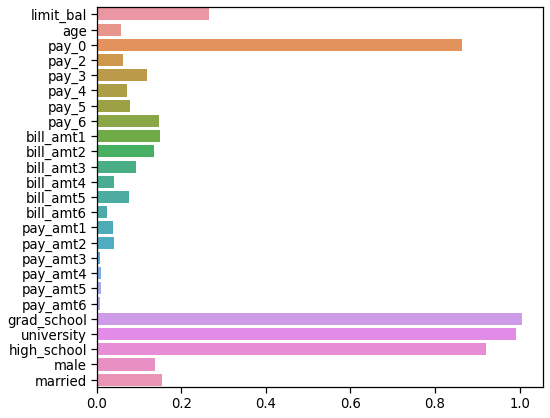

In [14]:
logistic_regression.coef_[0]
default.columns
f,ax = plt.subplots(figsize=(8, 7))
coef_plot = sns.barplot(y=default.columns.drop('default'),x=abs(logistic_regression.coef_[0]))

Ao observar o gráfico, fica visível que os dados de pay_amt1 a pay_amt6 oferecem pouca informação para o modelo.

### Analisando a correlação entre as features
Outro fator importante a ser analisado é a correlação entre os dados, posto que, quando há grande correlação, os dados não oferecem tanta informação para o modelo.
Diante disso, é válido observar o heatmap que demonstra a correlação entre as features utilizadas.

Text(0.5, 1.0, 'MATRIZ DE CORRELAÇÃO - HEATMAP')

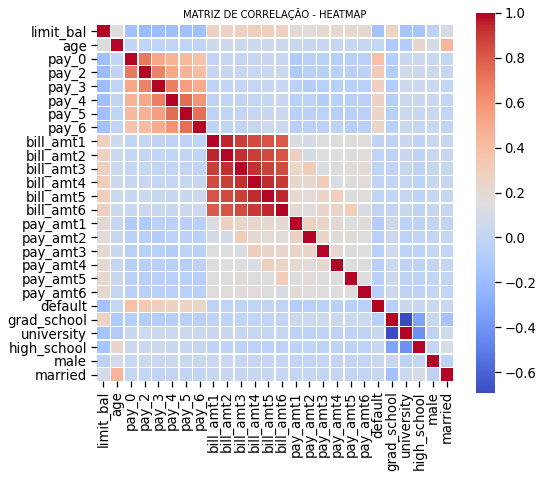

In [15]:
corr = default.corr() 
f,ax = plt.subplots(figsize=(8, 7))
sns.heatmap(corr, cbar = True,  square = True, annot = False, fmt= '.1f', 
            xticklabels= True, yticklabels= True
            ,cmap="coolwarm", linewidths=.5, ax=ax)

plt.title('MATRIZ DE CORRELAÇÃO - HEATMAP', size=10)

Com esse plot, fica visível a correlação entre os bill_amt. Dessa forma, é possível concluir que a bill_amt de um mês é suficiente para o modelo, tendo em vista que as bill_amts de outros meses apenas repetem a mesma informação.

Após essa análise, conclui-se que é recomendável remover do modelo pay_amt1, pay_amt2,..., pay_amt6 e bill_amt1,bill_amt2,...,bill_amt5, visto que, acrescentam pouca informação ao modelo. Desse modo, pensando na implementação em larga escala, a remoção dessas 11 features pode diminuir bastante os custos de processamento, armazenamento e coleta de dados de uma empresa. 

## Re-implementando o modelo

Diante das alterações do conjunto, faz-se necessário re-implementar o modelo e avaliar as alterações nas métricas de predição.

In [16]:
#Removendo as features
default2 = default.copy().drop(['pay_amt1','pay_amt2','pay_amt3','pay_amt4','pay_amt5','pay_amt6','bill_amt1','bill_amt2','bill_amt3','bill_amt5'],axis=1)
y_2 = default2['default']
X_2 = default2.copy().drop('default',axis=1)

#Removendo os outliers e normalizando 
robust_scaler_2 = RobustScaler()
X_2 = robust_scaler_2.fit_transform(X_2)

#Separando os Dados
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2,y_2, test_size=0.15, random_state = 123, stratify=y_2)

#Reimplementado o modelo
logistic_regression_2 = LogisticRegression(n_jobs=-1, random_state=15)

logistic_regression_2.fit(X_train_2,y_train_2)

metrics_model_2 = model_metrics(X_test_2,y_test_2,logistic_regression_2)


### Comparando resultados

Com os resultados da nova implementação, é possível concluir que, realmente, os dados removidos eram irrelevantes. O gráfico demonstra a precisão, acurácia e recall das duas implementações

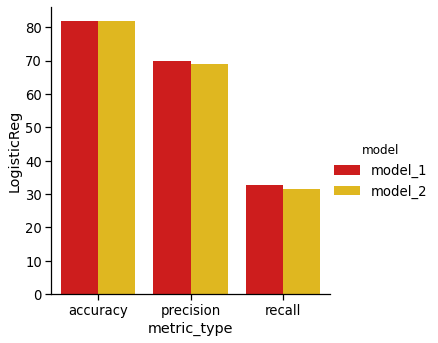

In [17]:
metrics_model_2['model'] = 'model_2'
metrics_model_1['model'] = 'model_1'
g = sns.catplot(data=pd.concat([metrics_model_1,metrics_model_2]), kind='bar', y='LogisticReg',x='metric_type',hue='model',palette="hot")

## Utilizando PCA
O Principal Component Analysys (PCA), é uma operação linear que utiliza Singular Value Decomposition(SVD) para reduzir um conjunto de features possivelmente correlacionadas num conjunto de valores de variáveis linearmente não correlacionadas chamadas de componentes principais. 

### Matemática do PCA(exemplo explicativo)
Seja o conjunto de dados representado por X. 
No cálculo do PCA, primeiramente, obtem-se a média dos $n$ valores de cada coluna de X.
$$
\frac{\sum_{j}{X_{ji}}}{n}
$$
Agora, é necessário determinar a matriz de coavariancia, para tal, considere uma matriz auxiliar $M$ obtida da seguinte forma:
$$
M = X-\frac{\sum_{j}{X_{ji}}}{n}
$$
Logo, a matriz de covariância C é:
$$
C = \frac{M^TM}{n-1}
$$

Diante disso, é preciso calcular os auto-valores e auto-vetores da matriz $C$. Os auto-valores $\lambda$ de $C$ são raízes do seguinte polinômio característico:
$$
p_{C}(Y)= det(C-YI)
$$

E os auto-vetores $q$ pertencem ao conjunto:
$$
(C-\lambda I)q = 0
$$

Faz-se necessário calcular o quanto cada auto-vetor(componentes) representa na taxa de variação dos dados, para isso vamos analisar a variância de cada auto-valor:
$$
var(\lambda) = \frac{\lambda}{\sum_{j}{\lambda_{j}}}
$$
Logo, com o conjunto das variâncias dos auto-valores pode-se determinar as componentes principais do dado conjunto. A importância de cada componente é dada pelo valor da variância do auto-valor correspondente.

### Reduzindo o conjunto de dados às 13 principais componentes

In [18]:
from sklearn.decomposition import PCA
#Definindo a dimensão dos dados
pca = PCA(13)
#PCA no conjunto de treino
pca_X = pca.fit(X)

X_pca = pd.DataFrame(pca_X.transform(X))
X_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-3.339702,1.209778,-0.426773,0.309149,0.165696,-0.348627,1.198143,0.979059,-0.527199,-2.040542,0.327953,-0.395656,-0.377187
1,-2.915311,0.797967,-0.547978,0.430450,0.294873,-0.554742,1.188430,0.905603,-0.865733,-0.123057,0.343460,-0.114453,-0.473279
2,-2.246350,0.234234,-0.976335,0.378132,0.169322,-0.271923,0.824479,-0.652101,-0.423994,-0.018693,0.645410,-0.135668,-0.207824
3,-2.267245,0.837629,-0.186583,0.242701,0.055321,-0.024043,-0.120276,-0.699375,0.122118,-0.060957,0.939178,-0.014449,-0.118082
4,4.589981,5.525321,-0.296593,0.641106,1.701635,-2.372474,1.211485,-0.488318,1.489474,0.016355,1.112877,-0.273168,0.336463


In [19]:
#Fazendo o split no conjunto reduzido
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size = 0.15, random_state = 123, stratify = y)

In [20]:
from sklearn.linear_model import LogisticRegression

#2. Criando uma instância para estimar
logistic_regression_pca = LogisticRegression(n_jobs=-1, random_state=15)

#3. Usando os dados de treino para treinar o modelo
logistic_regression_pca.fit(X_train_pca,y_train);



In [21]:
metrics_model_pca = model_metrics(X_test_pca,y_test,logistic_regression_pca)

### Nova correlação entre as veriáveis

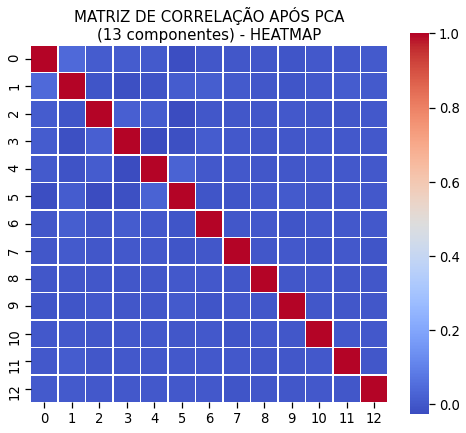

In [22]:
corr = X_train_pca.corr() 
f,ax = plt.subplots(figsize=(8, 7))
sns.heatmap(corr, cbar = True,  square = True, annot = False, fmt= '.1f', 
            xticklabels= True, yticklabels= True
            ,cmap="coolwarm", linewidths=.5, ax=ax)
plt.title(f'MATRIZ DE CORRELAÇÃO APÓS PCA\n({len(X_test_pca.columns)} componentes) - HEATMAP', size=15);

### Reduzindo o conjunto de dados às 9 principais componentes
#### Apenas a título de comparação das métricas

In [23]:
#Definindo a dimensão dos dados
pca = PCA(9)
#PCA no conjunto de treino
pca_X = pca.fit(X)

X_pca = pd.DataFrame(pca_X.transform(X))

#Fazendo o split no conjunto reduzido
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size = 0.15, random_state = 123, stratify = y)

#2. Criando uma instância para estimar
logistic_regression_pca = LogisticRegression(n_jobs=-1, random_state=15)

#3. Usando os dados de treino para treinar o modelo
logistic_regression_pca.fit(X_train_pca,y_train)

metrics_model_pca9 = model_metrics(X_test_pca,y_test,logistic_regression_pca)



## Avaliando as métricas

In [24]:
y_pred_test1 = logistic_regression.predict(X_test)
CM1 = confusion_matrix(y_pred = y_pred_test1, y_true = y_test)

y_pred_test2 = logistic_regression_2.predict(X_test_2)
CM2 = confusion_matrix(y_pred = y_pred_test2, y_true = y_test)

pca = PCA(13)
pca_X = pca.fit(X)
X_pca = pd.DataFrame(pca_X.transform(X))
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size = 0.15, random_state = 123, stratify = y)
logistic_regression_pca = LogisticRegression(n_jobs=-1, random_state=15)
logistic_regression_pca.fit(X_train_pca,y_train)

y_pred_test_pca13 = logistic_regression_pca.predict(X_test_pca)
CM13 = confusion_matrix(y_pred = y_pred_test_pca13, y_true = y_test)

pca = PCA(9)
pca_X = pca.fit(X)
X_pca = pd.DataFrame(pca_X.transform(X))
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size = 0.15, random_state = 123, stratify = y)
logistic_regression_pca = LogisticRegression(n_jobs=-1, random_state=15)
logistic_regression_pca.fit(X_train_pca,y_train)

y_pred_test_pca9 = logistic_regression_pca.predict(X_test_pca)
CM9 = confusion_matrix(y_pred = y_pred_test_pca9, y_true = y_test)

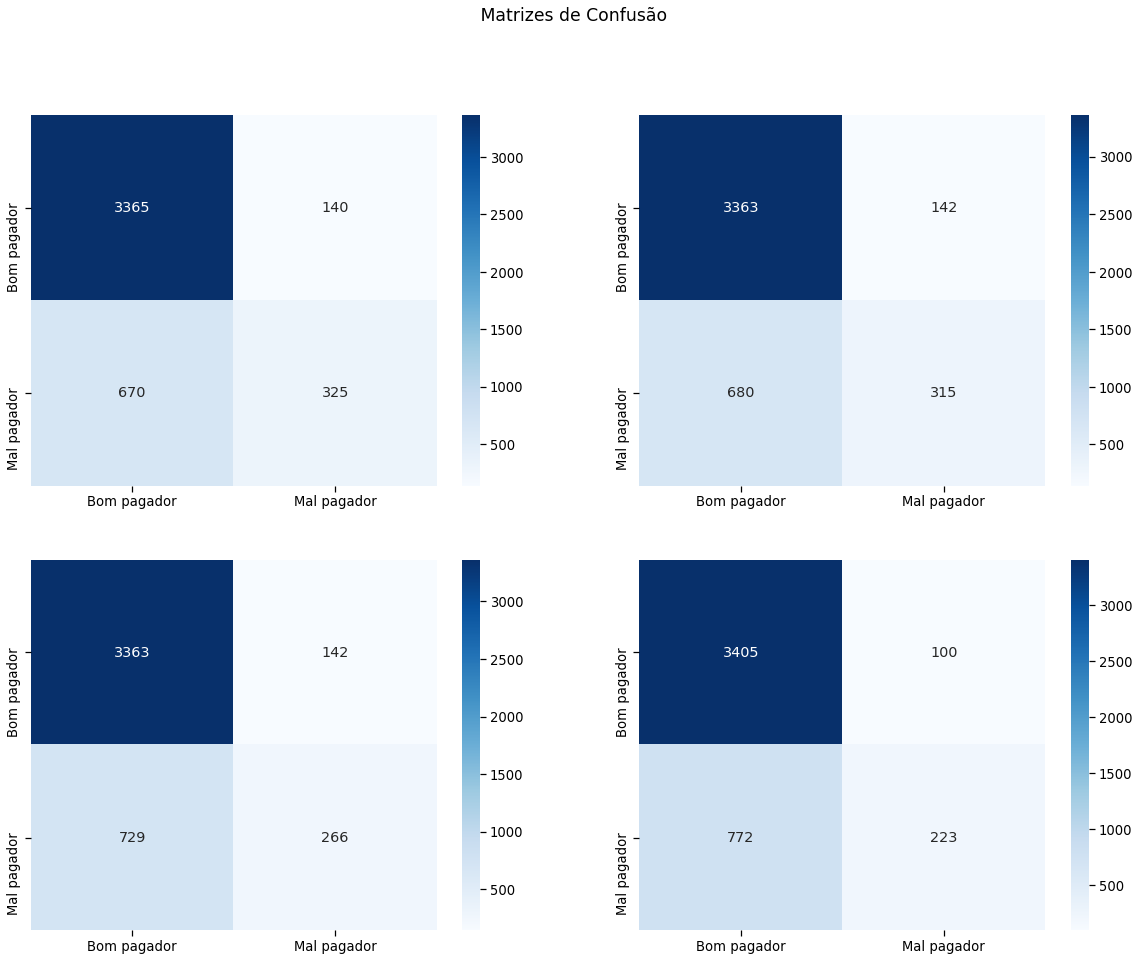

<Figure size 72x72 with 0 Axes>

<Figure size 72x72 with 0 Axes>

<Figure size 72x72 with 0 Axes>

<Figure size 72x72 with 0 Axes>

In [25]:

f, axes = plt.subplots(2, 2, figsize=(20, 15), facecolor='white')
f.suptitle(' Matrizes de Confusão')

plt.figure(figsize=(1, 1))
ax1 = sns.heatmap(CM1,annot=True, cmap="Blues", fmt="d",
            xticklabels = ['Bom pagador', 'Mal pagador'], 
            yticklabels = ['Bom pagador', 'Mal pagador'], ax=axes[0,0])

plt.figure(figsize=(1, 1))
ax2 = sns.heatmap(CM2,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['Bom pagador', 'Mal pagador'], 
            yticklabels = ['Bom pagador', 'Mal pagador'], ax=axes[0,1])
    
plt.figure(figsize=(1, 1))
ax3 = sns.heatmap(CM13,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['Bom pagador', 'Mal pagador'], 
            yticklabels = ['Bom pagador', 'Mal pagador'], ax=axes[1,0])

plt.figure(figsize=(1, 1))
ax4 = sns.heatmap(CM9,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['Bom pagador', 'Mal pagador'], 
            yticklabels = ['Bom pagador', 'Mal pagador'], ax=axes[1,1]);


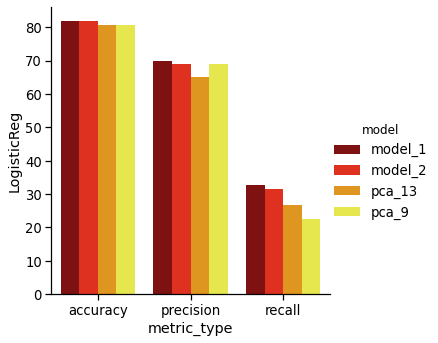

In [26]:
metrics_model_2['model'] = 'model_2'
metrics_model_1['model'] = 'model_1'
metrics_model_pca['model'] = 'pca_13'
metrics_model_pca9['model'] = 'pca_9'
g = sns.catplot(data=pd.concat([metrics_model_1,metrics_model_2,metrics_model_pca,metrics_model_pca9]), kind='bar', y='LogisticReg',x='metric_type',hue='model',palette="hot")

# Simulação 

### Função para receber dados externos

In [27]:
def cadastro(cliente):

    #transformando o dict em série
    cliente = pd.Series(cliente)

    #dimensionando e normalizando
    info = cliente.values.reshape(1, -1)
    info = robust_scaler.transform(info)

    #como "info" e "X" são np array, vamos converter para dataframe
    info = pd.DataFrame(info, columns = default.drop("default", axis = 1).columns)

    #vamos concatenar essa linha aos dados originais
    novos_dados = pd.concat([info, X])

    return novos_dados

In [28]:
def teste(novos_dados):
    
    #Definindo a dimensão do dado

    pca_function = PCA(9)

    try:
        pca_function_teste = pca_function.fit(novos_dados)
        dado_reduzido = pd.DataFrame(pca_function_teste.transform(novos_dados))

        
        prob = logistic_regression_pca.predict_proba(dado_reduzido[:1])[0][1]
        
        if prob >= 0.25:
            print(f"Esse vai dever\n\nScore: {round(100/prob, 3)}\nProb de dever: {round(prob*100, 2)}%")
        else:
            print(f"Camarada que paga!\n\nScore: {round(100/prob, 3)}\nProb de dever: {round(prob*100, 2)}%")
        
    except ValueError:
        print("Dado com dimensão grande demais")


In [29]:
yuri = OrderedDict([("limit_bal", 4000), ("age", 30), ("pay_0", -5), ("pay_2", 0),("pay_3", 0), ("pay_4", 0), ("pay_5", 0), ("pay_6", 0), ("bill_amt1", 500), ("bill_amt2", 30009), ("bill_amt3", 200), ("bill_amt4", 0), ("bill_amt5", 0), ("bill_amt6", 0), ("pay_amt1", 500), ("pay_amt2", 309), ("pay_amt3", 200), ("pay_amt4", 0), ("pay_amt5", 0), ("pay_amt6", 0), ("male", 1), ("grad_school", 0), ("university", 1), ("high_school", 0), ("married", 0)])

cliente = cadastro(yuri)
teste(cliente)

Camarada que paga!

Score: 1494.585
Prob de dever: 6.69%


In [30]:
luiz = OrderedDict([("limit_bal", 1000), ("age", 19), ("pay_0", 0), ("pay_2", 0),("pay_3", 0), ("pay_4", 0), ("pay_5", 0), ("pay_6", 0), ("bill_amt1", 750), ("bill_amt2", 0), ("bill_amt3", 0), ("bill_amt4", 0), ("bill_amt5", 0), ("bill_amt6", 0), ("pay_amt1", 100), ("pay_amt2", 0), ("pay_amt3", 0), ("pay_amt4", 0), ("pay_amt5", 0), ("pay_amt6", 800), ("male", 1), ("grad_school", 0), ("university", 1), ("high_school", 0), ("married", 0)])

cliente2 = cadastro(luiz)
teste(cliente2)

Camarada que paga!

Score: 640.948
Prob de dever: 15.6%


In [31]:
gustavo = OrderedDict([("limit_bal", 30000), ("age", 19), ("pay_0", 3), ("pay_2", 4),("pay_3", 5), ("pay_4", 6), ("pay_5", 7), ("pay_6", 0), ("bill_amt1", 150), ("bill_amt2", 300), ("bill_amt3", 450), ("bill_amt4", 650), ("bill_amt5", 800), ("bill_amt6", 0), ("pay_amt1", 100), ("pay_amt2", 0), ("pay_amt3", 0), ("pay_amt4", 0), ("pay_amt5", 0), ("pay_amt6", 0), ("male", 1), ("grad_school", 0), ("university", 1), ("high_school", 0), ("married", 0)])

cliente3 = cadastro(gustavo)
teste(cliente3)

Esse vai dever

Score: 102.178
Prob de dever: 97.87%


In [32]:
ari = OrderedDict([("limit_bal", 3000), ("age", 19), ("pay_0", 0), ("pay_2", -1),("pay_3", -2), ("pay_4", -3), ("pay_5", 0), ("pay_6", 1), ("bill_amt1", 0), ("bill_amt2", 0), ("bill_amt3", 0), ("bill_amt4", 0), ("bill_amt5",0), ("bill_amt6", 40), ("pay_amt1", 100), ("pay_amt2", 150), ("pay_amt3", 150), ("pay_amt4", 150), ("pay_amt5", 0), ("pay_amt6", 0), ("male", 1), ("grad_school", 0), ("university", 1), ("high_school", 0), ("married", 0)])


cliente4 = cadastro(ari)
teste(cliente4)

Camarada que paga!

Score: 1908.339
Prob de dever: 5.24%


# Referencias e dados

Logistic Regression - THE MATH YOU SHOULD KNOW
https://www.youtube.com/watch?v=YMJtsYIp4kg
    
https://www.kaggle.com/selener/prediction-of-credit-card-default/notebook

Logistic Regression Details Pt1: Coefficients
https://www.youtube.com/watch?v=BfKanl1aSG0

Logistic Regression Details Pt 2: Maximum Likelihood
https://www.youtube.com/watch?v=BfKanl1aSG0&t=383s

Making Predictions with Data and Python : Predicting Credit Card Default | packtpub.com
https://www.youtube.com/watch?v=zUqa6KcwRhs&app=desktop
